In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import os
import sys
import time
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split

sys.path.append('..')
from src.model.encoders import DanceEncoder, SimpleTextEncoder
from src.model.loss import NTXentLoss
from src.model.trainer import ContrastiveTrainer

In [ ]:
# Load labeled dataset
try:
    dataset = np.load('../data/processed/labeled_dataset.npy', allow_pickle=True).item()
    sequences = dataset['sequences']
    labels = dataset['labels']
    print(f"Loaded dataset with {len(sequences)} sequences and {len(labels)} labels")
except:
    try:
        sequences = np.load('../data/processed/dance_sequences.npy')
        
        try:
            label_data = np.load('../data/processed/sequence_labels.npy', allow_pickle=True).item()
            labels = label_data['labels']
        except:
            print("Labels not found. Creating placeholder labels for demonstration.")
            labels = [f"Dance movement {i}" for i in range(len(sequences))]
        
        print(f"Loaded {len(sequences)} sequences and {len(labels)} labels")
    except:
        print("No dataset files found. Please run the previous notebooks first.")
        sequences = None
        labels = None

Loaded dataset with 2022 sequences and 2022 labels


In [ ]:
# Dataset preparation
if 'sequences' in locals() and sequences is not None and 'labels' in locals() and labels is not None:
    class DanceTextDataset(Dataset):
        """Dataset for dance sequences and text labels"""
        
        def __init__(self, sequences, labels, text_vocab=None):
            """
            Initialize dataset
            
            Args:
                sequences: Dance sequences array with shape (n_sequences, n_joints, seq_length, 3)
                labels: List of text labels
                text_vocab: Vocabulary for text tokenization (if None, creates a new one)
            """
            self.sequences = sequences
            self.text_labels = labels
     
            if text_vocab is None:
                self.build_vocabulary()
            else:
                self.vocab = text_vocab
                self.word_to_index = {word: i for i, word in enumerate(self.vocab)}
            
            print(f"Dataset created with {len(sequences)} samples and vocabulary size {len(self.vocab)}")
        def build_vocabulary(self):
            """Build a vocabulary from all words in the labels"""
            all_words = set()
            for label in self.text_labels:
                words = label.lower().strip().split()
                all_words.update(words)
            
            # Create vocabulary (add special tokens)
            self.vocab = ['<pad>', '<unk>'] + sorted(list(all_words))
            self.word_to_index = {word: i for i, word in enumerate(self.vocab)}
            
            print(f"Built vocabulary with {len(self.vocab)} words")
        
        def tokenize(self, text):
            """Convert text to token indices and return length"""
            words = text.lower().strip().split()
            
            indices = [self.word_to_index.get(word, 1) for word in words] 
            
            return indices, len(indices)
        def __len__(self):
            return len(self.sequences)
        
        def __getitem__(self, idx):
            sequence = self.sequences[idx].astype(np.float32)
            
            text = self.text_labels[idx]
            tokens, length = self.tokenize(text)
            
            sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
            tokens_tensor = torch.tensor(tokens, dtype=torch.long)
            length_tensor = torch.tensor(length, dtype=torch.long)
            
            return sequence_tensor, tokens_tensor, length_tensor
    full_dataset = DanceTextDataset(sequences, labels)

    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    print(f"Dataset split: {train_size} train, {val_size} validation, {test_size} test samples")
    
    batch_size = 32
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=0, pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True if torch.cuda.is_available() else False
    )

Built vocabulary with 28 words
Dataset created with 2022 samples and vocabulary size 28
Dataset split: 1415 train, 303 validation, 304 test samples


In [ ]:
# Model architecture
if 'full_dataset' in locals():
 
    n_joints, seq_length, n_dims = sequences[0].shape
    vocab_size = len(full_dataset.vocab)
    embedding_dim = 128 
    
    dance_encoder = DanceEncoder(
        n_joints=n_joints,
        seq_length=seq_length,
        n_dims=n_dims,
        embedding_dim=embedding_dim
    )
    text_encoder = SimpleTextEncoder(
        input_dim=vocab_size,  
        embedding_dim=embedding_dim
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    trainer = ContrastiveTrainer(
        dance_encoder=dance_encoder,
        text_encoder=text_encoder,
        device=device,
        learning_rate=0.001,
        temperature=0.07
    )
    
    def text_to_bow(tokens_tensor, vocab_size):
        """Convert token indices to bag-of-words representation"""
        bow = torch.zeros(tokens_tensor.shape[0], vocab_size, device=tokens_tensor.device)
        for i in range(tokens_tensor.shape[0]):
            for token in tokens_tensor[i]:
                if token >= 0 and token < vocab_size:
                    bow[i, token] = 1
        return bow

    def collate_fn(batch):
        """Custom collate function to handle variable length text sequences"""
   
        sequences, tokens, lengths = zip(*batch)
        

        sequences = torch.stack(sequences)
        

        max_len = max(len(t) for t in tokens)
        padded_tokens = torch.zeros(len(tokens), max_len, dtype=torch.long)
        for i, t in enumerate(tokens):
            padded_tokens[i, :len(t)] = t
        

        bow_vectors = text_to_bow(padded_tokens, vocab_size)
        
        return sequences, bow_vectors, None 
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        collate_fn=collate_fn, num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=collate_fn, num_workers=0
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        collate_fn=collate_fn, num_workers=0
    )

Using device: cpu


Starting model training...


Training: 100%|██████████| 45/45 [00:01<00:00, 37.50it/s, acc=0.286, loss=1.5]  


Epoch 1: Train Loss: 3.2470, Train Acc: 0.0633, Val Loss: 3.0434, Val Acc: 0.1017


Training: 100%|██████████| 45/45 [00:01<00:00, 43.38it/s, acc=0.286, loss=1.5]  


Epoch 2: Train Loss: 3.0460, Train Acc: 0.0911, Val Loss: 2.9763, Val Acc: 0.1013


Training: 100%|██████████| 45/45 [00:00<00:00, 46.54it/s, acc=0.143, loss=2.03] 


Epoch 3: Train Loss: 2.9614, Train Acc: 0.0990, Val Loss: 2.9630, Val Acc: 0.0954


Training: 100%|██████████| 45/45 [00:00<00:00, 45.02it/s, acc=0.429, loss=1.2]  


Epoch 4: Train Loss: 2.8628, Train Acc: 0.1047, Val Loss: 2.9215, Val Acc: 0.0977


Training: 100%|██████████| 45/45 [00:00<00:00, 46.90it/s, acc=0.286, loss=1.44] 


Epoch 5: Train Loss: 2.8561, Train Acc: 0.1050, Val Loss: 3.1915, Val Acc: 0.0860


Training: 100%|██████████| 45/45 [00:01<00:00, 44.00it/s, acc=0.571, loss=1.04] 


Epoch 6: Train Loss: 2.8171, Train Acc: 0.1176, Val Loss: 2.9601, Val Acc: 0.1048


Training: 100%|██████████| 45/45 [00:01<00:00, 38.73it/s, acc=0.286, loss=1.55] 


Epoch 7: Train Loss: 2.7621, Train Acc: 0.1237, Val Loss: 2.9566, Val Acc: 0.1079


Training: 100%|██████████| 45/45 [00:01<00:00, 34.17it/s, acc=0.429, loss=1.29] 


Epoch 8: Train Loss: 2.7353, Train Acc: 0.1137, Val Loss: 2.8803, Val Acc: 0.1142


Training: 100%|██████████| 45/45 [00:01<00:00, 37.06it/s, acc=0.714, loss=0.87] 


Epoch 9: Train Loss: 2.7000, Train Acc: 0.1388, Val Loss: 2.9228, Val Acc: 0.1017


Training: 100%|██████████| 45/45 [00:01<00:00, 41.60it/s, acc=0.286, loss=1.62] 


Epoch 10: Train Loss: 2.6570, Train Acc: 0.1258, Val Loss: 3.1971, Val Acc: 0.0946


Training: 100%|██████████| 45/45 [00:02<00:00, 19.27it/s, acc=0.571, loss=0.98] 


Epoch 11: Train Loss: 2.6721, Train Acc: 0.1259, Val Loss: 3.1367, Val Acc: 0.1017


Training: 100%|██████████| 45/45 [00:01<00:00, 30.48it/s, acc=0.143, loss=1.2]  


Epoch 12: Train Loss: 2.5539, Train Acc: 0.1351, Val Loss: 3.0208, Val Acc: 0.0950


Training: 100%|██████████| 45/45 [00:01<00:00, 31.51it/s, acc=0.571, loss=0.88] 


Epoch 13: Train Loss: 2.5789, Train Acc: 0.1391, Val Loss: 2.9738, Val Acc: 0.1106


Training: 100%|██████████| 45/45 [00:01<00:00, 44.90it/s, acc=0.286, loss=1.61] 


Epoch 14: Train Loss: 2.5175, Train Acc: 0.1411, Val Loss: 3.1780, Val Acc: 0.0985


Training: 100%|██████████| 45/45 [00:00<00:00, 46.90it/s, acc=0.429, loss=1.33] 


Epoch 15: Train Loss: 2.5993, Train Acc: 0.1324, Val Loss: 3.4024, Val Acc: 0.0915


Training: 100%|██████████| 45/45 [00:01<00:00, 42.51it/s, acc=0.429, loss=1.1]  


Epoch 16: Train Loss: 2.5066, Train Acc: 0.1380, Val Loss: 2.9708, Val Acc: 0.1075


Training: 100%|██████████| 45/45 [00:00<00:00, 45.00it/s, acc=0.429, loss=1.09] 


Epoch 17: Train Loss: 2.4369, Train Acc: 0.1456, Val Loss: 3.0363, Val Acc: 0.1204


Training: 100%|██████████| 45/45 [00:00<00:00, 46.85it/s, acc=0.429, loss=0.919]


Training completed in 24.21 seconds


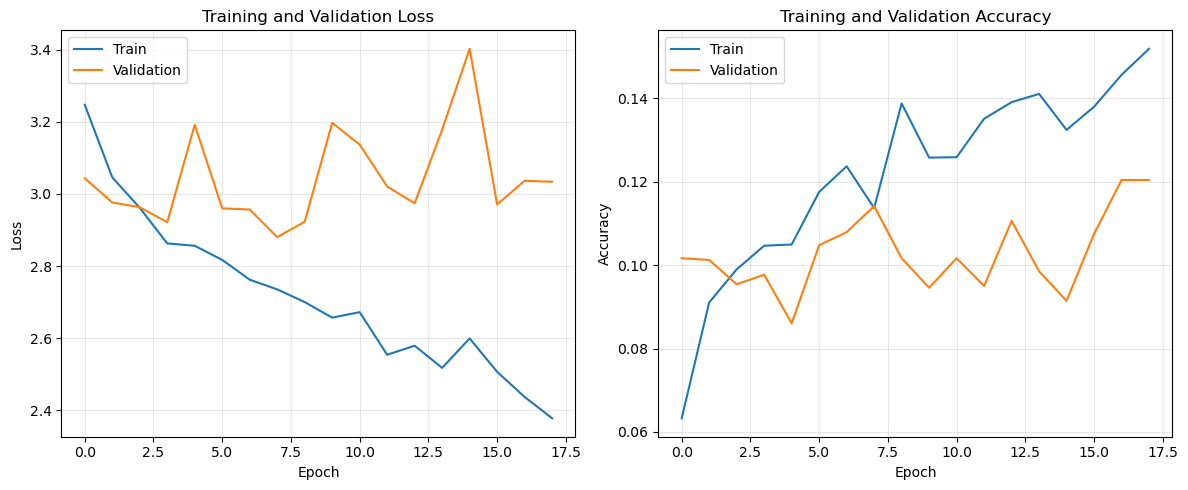

In [ ]:
# Train the model
if 'trainer' in locals() and 'train_loader' in locals() and 'val_loader' in locals():
 
    num_epochs = 50
    early_stopping_patience = 10
    
    if not os.path.exists('../results/models'):
        os.makedirs('../results/models')
    def log_progress(epoch_stats):
        """Log progress information during training"""
        print(f"Epoch {epoch_stats['epoch']+1}: "
              f"Train Loss: {epoch_stats['train_loss']:.4f}, "
              f"Train Acc: {epoch_stats['train_acc']:.4f}, "
              f"Val Loss: {epoch_stats['val_loss']:.4f}, "
              f"Val Acc: {epoch_stats['val_acc']:.4f}")
    
    # Train the model
    print("Starting model training...")
    start_time = time.time()
    
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        early_stopping_patience=early_stopping_patience,
        save_path='../results/models/contrastive_model.pt',
        callback=log_progress
    )
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if not os.path.exists('../results/figures'):
        os.makedirs('../results/figures')
    plt.savefig('../results/figures/training_history.png')
    plt.show()


In [ ]:
# Evaluate model on test set
if 'trainer' in locals() and 'test_loader' in locals():

    test_loss, test_acc = trainer.validate(test_loader)
    
    print(f"Test results: Loss = {test_loss:.4f}, Accuracy = {test_acc:.4f}")
    
    
    # Compute embeddings for all test examples for later use
    test_dance_embeddings, test_dance_sequences = trainer.compute_embeddings(test_loader, type='dance')
    test_text_embeddings, test_text_tokens = trainer.compute_embeddings(test_loader, type='text')
    
    if not os.path.exists('../results/embeddings'):
        os.makedirs('../results/embeddings')
    
    np.save('../results/embeddings/test_dance_embeddings.npy', test_dance_embeddings)
    np.save('../results/embeddings/test_text_embeddings.npy', test_text_embeddings)
    print("Test embeddings saved to '../results/embeddings/'")


Test results: Loss = 3.1516, Accuracy = 0.1062


Computing text embeddings: 100%|██████████| 10/10 [00:00<00:00, 357.04it/s]

Test embeddings saved to '../results/embeddings/'


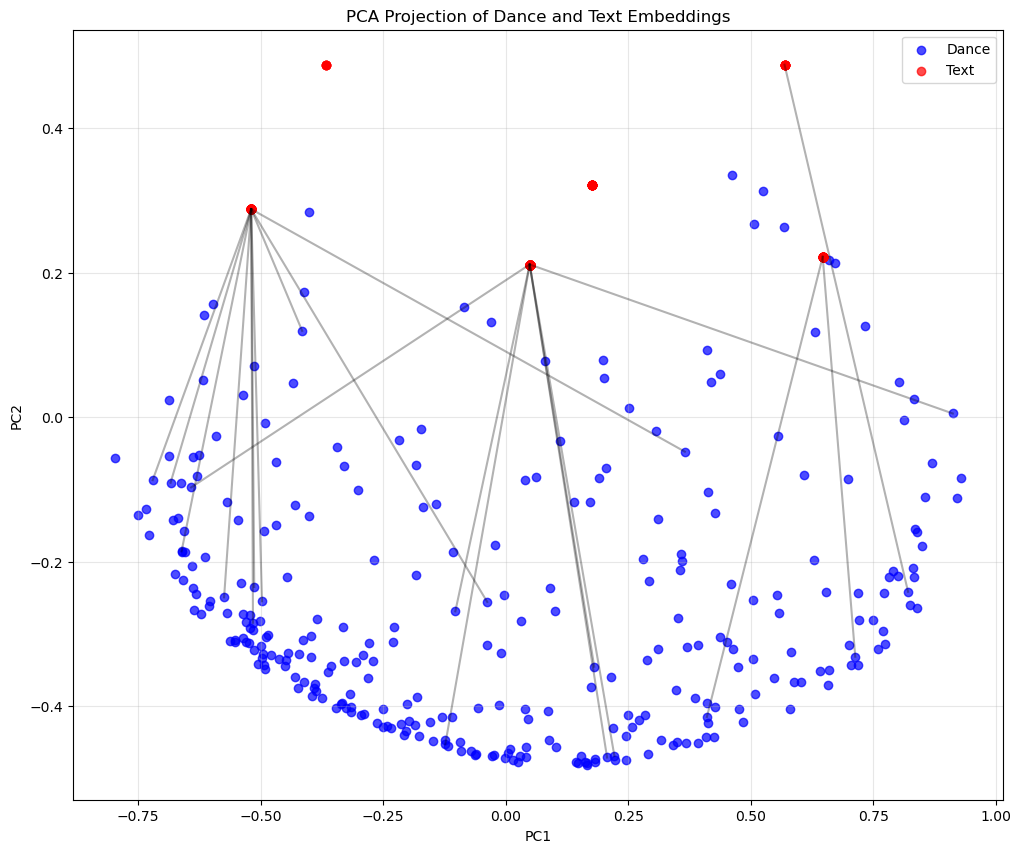

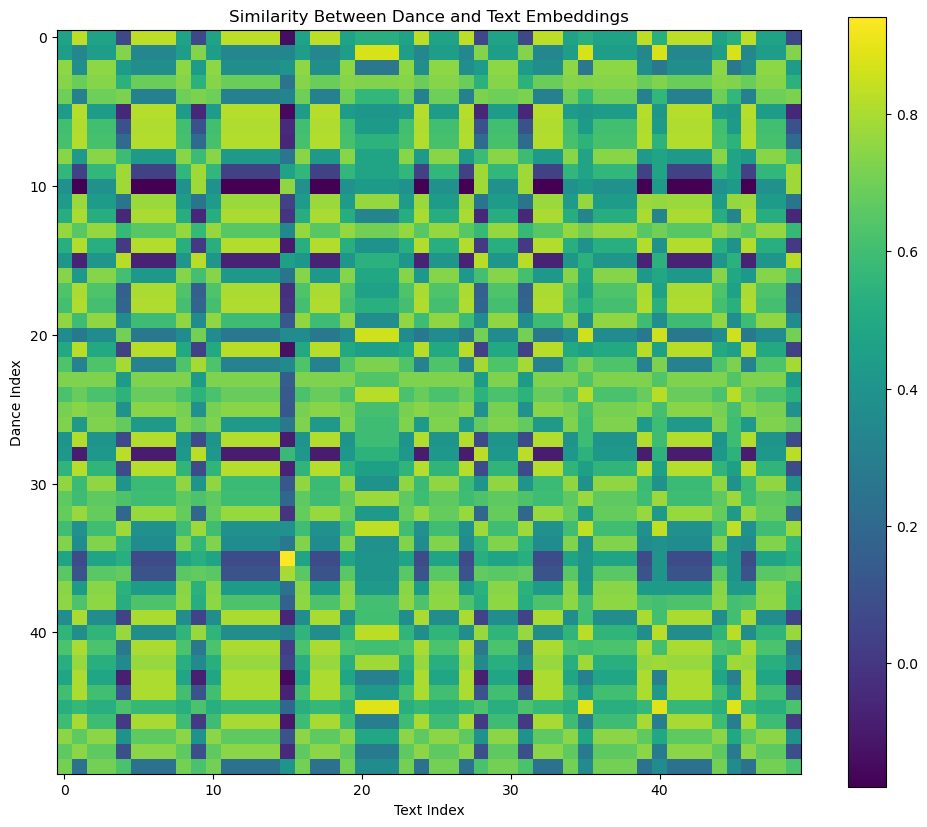

In [ ]:
#Visualize embeddings
if 'test_dance_embeddings' in locals() and 'test_text_embeddings' in locals():

    from sklearn.decomposition import PCA
    
    all_embeddings = np.vstack([test_dance_embeddings, test_text_embeddings])
    
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    
    n_test = len(test_dance_embeddings)
    dance_reduced = reduced_embeddings[:n_test]
    text_reduced = reduced_embeddings[n_test:]
    
    plt.figure(figsize=(12, 10))
    
    plt.scatter(dance_reduced[:, 0], dance_reduced[:, 1], 
               color='blue', label='Dance', alpha=0.7)
    
    plt.scatter(text_reduced[:, 0], text_reduced[:, 1], 
               color='red', label='Text', alpha=0.7)
    for i in range(min(20, n_test)):  
        plt.plot([dance_reduced[i, 0], text_reduced[i, 0]],
                [dance_reduced[i, 1], text_reduced[i, 1]],
                'k-', alpha=0.3)
    
    plt.title('PCA Projection of Dance and Text Embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('../results/figures/embedding_visualization.png')
    plt.show()
    
    similarity = np.dot(test_dance_embeddings, test_text_embeddings.T)
    
    n_samples = min(50, similarity.shape[0])
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity[:n_samples, :n_samples], cmap='viridis')
    plt.colorbar()
    plt.title('Similarity Between Dance and Text Embeddings')
    plt.xlabel('Text Index')
    plt.ylabel('Dance Index')
    
    plt.grid(False)
    plt.savefig('../results/figures/similarity_matrix.png')
    plt.show()